# Implementando os Atratores


## Bibliotecas


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import pandas as pd
import tensorflow as tf
import tensorflow.keras as kr
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
import plotly.graph_objects as go


#!pip install --upgrade matplotlib

# Métodos de resolução numérica de EDO's

In [ ]:
def Euler(fun, initial_cond, h, coef, n_points):

    y = np.zeros((n_points,3))
    y[0] = initial_cond

    for i in range(1 , n_points):

        y[i] = y[i-1] + h*fun(y[i-1], coef)

    return y


def RK4(fun, initial_cond, h, coef, n_points):

    y = np.zeros((n_points,3))
    y[0] = initial_cond

    for i in range(1 , n_points):

        aux0 = h*fun(y[i-1], coef)
        aux1 = h*fun(y[i-1] + aux0/2, coef)
        aux2 = h*fun(y[i-1] + aux1/2, coef)
        aux3 = h*fun(y[i-1] + aux2, coef)
        y[i] = y[i-1] + (1/6)*(aux0 + 2*aux1 + 2*aux2 + aux3)

    return y

# Atrator de Lorentz

\
\begin{align*}
\frac{dx}{dt} &= a(y - x) \\
\frac{dy}{dt} &= x(b - z) - y \\
\frac{dz}{dt} &= xy - cz
\end{align*}



In [ ]:
def Lorentz(y, coef):

    res = np.zeros(y.shape)
    a, b, c = coef

    res[0] = a*(y[1] - y[0])
    res[1] = y[0]*(b - y[2]) - y[1]
    res[2] = y[0]*y[1] - c*y[2]

    return res

# Atrator de Aizawa

\
\begin{align*}
\frac{dx}{dt} &= (z- b)x - dy \\
\frac{dy}{dt} &= dx + (z - b)y \\
\frac{dz}{dt} &= c + az - \frac{z^3}{3} - (x^2 + y^2)(1 - ez) + f z x^3
\end{align*}


In [ ]:
def Aizawa(y, coef):

    res = np.zeros(y.shape)
    a, b, c, d, e, f = coef

    res[0] = (y[2] - b)*y[0] - d*y[1]
    res[1] = d*y[0] + (y[2] - b)*y[1]
    res[2] = c + a*y[2] - (y[2]**3)/3 - (y[0]**2 + y[1]**2)*(1 + e*y[2]) + f*y[2]*(y[0]**3)

    return res

# Atrator de Rossler

\
\begin{align*}
\frac{dx}{dt} &= - (y + z) \\
\frac{dy}{dt} &= x + ay \\
\frac{dz}{dt} &= b + z(x - c)
\end{align*}


In [ ]:
def Rossler(y, coef):

    res = np.zeros(y.shape)
    a, b, c = coef

    res[0] = -(y[1] + y[2])
    res[1] = y[0] + a*y[1]
    res[2] = b + y[2]*(y[0] - c)

    return res


# Seletor de atratores

In [ ]:
def Atrator(tipo, initial_cond, h, coef, n_points, método):
    return método(tipo, initial_cond, h, coef, n_points)

In [ ]:
h = 0.01
n_points = 200000
lorentz =  Atrator(tipo=Lorentz, initial_cond= np.array([-6,-6,15]),
                   h= h, coef= np.array([10, 28, 8/3]),
                   n_points= n_points, método= RK4)
rossler = Atrator(tipo=Rossler, initial_cond= np.array([0.1, 0.1, 0.1]), h= h,
                  coef= np.array([0.2, 0.2, 5.7]),
                  n_points= n_points, método= RK4)
aizawa = Atrator(tipo=Aizawa, initial_cond= np.array([0.1, 1, 0]), h= h,
                  coef= np.array([0.95, 0.7, 0.6, 3.5, 0.25, 0.1]),
                  n_points= n_points, método= RK4)

# Integração dos dados

In [ ]:
def prep_data(collection, n_points, n_infos):
  separado = []
  target = []
  sample_space = []
  for i in range(0, (n_points - (n_points % (n_infos + 1))), n_infos + 1):
    separado.append(collection[i:i+ n_infos + 1])

  for i in range(len(separado)):
    target.append(separado[i][-1])
    sample_space.append(separado[i][0: n_infos])

  return np.array(sample_space), np.array(target), np.array(separado)


# Testes iniciais com Redes Neurais Reais


In [ ]:
sample_space , target, dados_gerais = prep_data(aizawa, n_points, 4)

sample_space = sample_space.reshape((sample_space.shape[0], 1, 12))

X_treino, X_teste, y_treino, y_teste = train_test_split(sample_space, target, test_size= 0.2, random_state= 42)
X_val, X_teste, y_val, y_teste = train_test_split(X_teste, y_teste, test_size=0.6, random_state= 123)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(1,12)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3)
])


optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001)

model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12)                0         
                                                                 
 dense (Dense)               (None, 10)                130       
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 163 (652.00 Byte)
Trainable params: 163 (652.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:

history = model.fit(
  X_treino, y_treino,
  verbose=1,epochs=100,
  validation_data=(X_val, y_val))


Epoch 1/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0831 - mae: 0.1516 - val_loss: 0.0019 - val_mae: 0.0339
Epoch 2/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0010 - mae: 0.0242 - val_loss: 5.5156e-04 - val_mae: 0.0182
Epoch 3/100
1000/1000 [==============================] - 2s 2ms/step - loss: 3.6958e-04 - mae: 0.0147 - val_loss: 2.3712e-04 - val_mae: 0.0117
Epoch 4/100
1000/1000 [==============================] - 2s 2ms/step - loss: 1.5822e-04 - mae: 0.0094 - val_loss: 1.0621e-04 - val_mae: 0.0077
Epoch 5/100
1000/1000 [==============================] - 2s 2ms/step - loss: 7.0485e-05 - mae: 0.0062 - val_loss: 5.6467e-05 - val_mae: 0.0058
Epoch 6/100
1000/1000 [==============================] - 2s 2ms/step - loss: 4.7928e-05 - mae: 0.0051 - val_loss: 4.5893e-05 - val_mae: 0.0048
Epoch 7/100
1000/1000 [==============================] - 4s 4ms/step - loss: 3.8976e-05 - mae: 0.0046 - val_loss: 3.5307e-05 - val_mae: 0.0044
Epoch 8/100

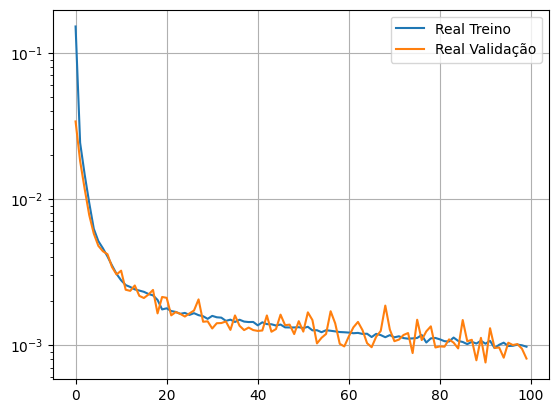

In [ ]:
#Results
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
index = np.arange(0,len(hist['epoch']))
plt.semilogy(hist['mae'],label='Real Treino')
plt.semilogy(hist['val_mae'],label='Real Validação')

plt.legend()
plt.grid()

In [ ]:
model.evaluate(X_teste, y_teste)
y_pred = model.predict(X_teste)

150/150 [==============================] - 0s 1ms/step


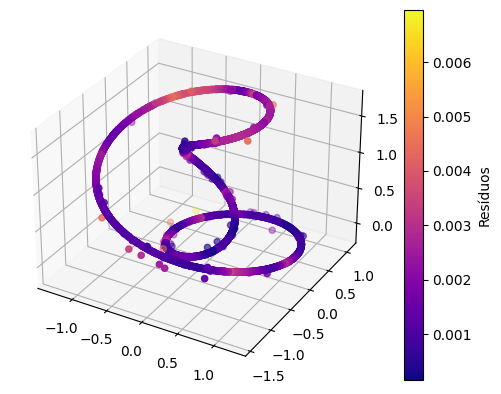

In [ ]:
residuos = []
for i in range(len(y_teste)):
  residuos.append(np.linalg.norm(y_teste[i]-y_pred[i]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(y_teste[:, 0], y_teste[:, 1], y_teste[:, 2], c=residuos, cmap='plasma')
cbar = plt.colorbar(scatter)
cbar.set_label('Resíduos')
plt.show()

# Testes Iniciais com Redes Neurais Complexas

In [ ]:
sample_space , target, dados_gerais = prep_data(aizawa, n_points, 4)
X_treino, X_teste, y_treino, y_teste = train_test_split(sample_space, target, test_size= 0.2, random_state= 42)
X_val, X_teste, y_val, y_teste = train_test_split(X_teste, y_teste, test_size=0.6, random_state= 123)

In [ ]:
def Real2Complex(X):
    return tf.concat([X,tf.zeros_like(X)],axis=1)

In [ ]:
y_treino, y_teste, y_val = Real2Complex(y_treino), Real2Complex(y_teste), Real2Complex(y_val)

In [ ]:
class ComplexDense(keras.layers.Layer):
  def __init__(self, units=32, use_bias=True, activation=None):
    super(ComplexDense, self).__init__()
    self.units = units
    self.use_bias = use_bias
    self.activation = keras.activations.get(activation)

  def build(self, input_shape):
    assert input_shape[-1] % 2 == 0

    input_dim = input_shape[-1] // 2

    # Real-part of the weights
    self.u = self.add_weight(
    shape=(input_dim, self.units),
    initializer="glorot_uniform",
    trainable=True,
    )

    # Imaginary-part of the weights
    self.v = self.add_weight(
    shape=(input_dim, self.units),
    initializer="glorot_uniform",
    trainable=True,
    )

    # Bias complex-valued
    if self.use_bias:
      self.b = self.add_weight(
        shape=(2 * self.units,), initializer="zeros", trainable=True
    )
  def call(self, inputs):

    W = tf.concat([tf.concat([self.u,self.v],axis=1),tf.concat([-self.v,self.u],axis=1)],axis=0)

    outputs = tf.matmul(inputs, W)


    if self.use_bias:
      outputs = tf.nn.bias_add(outputs, self.b)

    if self.activation is not None:
      outputs = self.activation(outputs)

    return outputs

In [ ]:
X_treino = X_treino.reshape(X_treino.shape[0], X_treino.shape[1] * X_treino.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])
X_teste = X_teste.reshape(X_teste.shape[0], X_teste.shape[1] * X_teste.shape[2])

In [ ]:
input = keras.Input(shape=(X_treino.shape[1],))
input_complex = Real2Complex(input)
output_complex = ComplexDense(5, activation='relu')(input_complex)
output_final = ComplexDense(3, activation=None, use_bias=None)(output_complex)
single_complex = Model(inputs=input, outputs=output_final, name="complex_neuron")

In [ ]:
single_complex.summary()

Model: "complex_neuron"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 12)]                 0         []                            
                                                                                                  
 tf.zeros_like (TFOpLambda)  (None, 12)                   0         ['input_1[0][0]']             
                                                                                                  
 tf.concat (TFOpLambda)      (None, 24)                   0         ['input_1[0][0]',             
                                                                     'tf.zeros_like[0][0]']       
                                                                                                  
 complex_dense (ComplexDens  (None, 10)                   130       ['tf.concat[0][0]

In [ ]:
single_complex.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

In [ ]:
history = single_complex.fit(X_treino, y_treino,
epochs=100,
validation_data=(X_val,y_val), verbose=True)

Epoch 1/100
1000/1000 [==============================] - 3s 2ms/step - loss: 0.0734 - mae: 0.1631 - val_loss: 0.0077 - val_mae: 0.0595
Epoch 2/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0040 - mae: 0.0423 - val_loss: 0.0019 - val_mae: 0.0315
Epoch 3/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0012 - mae: 0.0248 - val_loss: 6.4784e-04 - val_mae: 0.0185
Epoch 4/100
1000/1000 [==============================] - 3s 3ms/step - loss: 3.9658e-04 - mae: 0.0148 - val_loss: 2.4297e-04 - val_mae: 0.0116
Epoch 5/100
1000/1000 [==============================] - 3s 3ms/step - loss: 1.8927e-04 - mae: 0.0097 - val_loss: 1.5854e-04 - val_mae: 0.0085
Epoch 6/100
1000/1000 [==============================] - 5s 5ms/step - loss: 1.5266e-04 - mae: 0.0082 - val_loss: 1.4700e-04 - val_mae: 0.0080
Epoch 7/100
1000/1000 [==============================] - 6s 6ms/step - loss: 1.3216e-04 - mae: 0.0076 - val_loss: 1.2453e-04 - val_mae: 0.0073
Epoch 8/100
1000/10

150/150 [==============================] - 0s 2ms/step


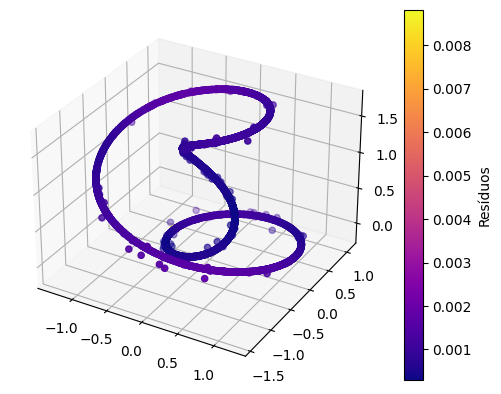

In [ ]:
single_complex.evaluate(X_teste, y_teste)
y_pred = single_complex.predict(X_teste)

residuos = []
for i in range(len(y_teste)):
  residuos.append(np.linalg.norm(y_teste[i]-y_pred[i]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(y_teste[:, 0], y_teste[:, 1], y_teste[:, 2], c=residuos, cmap='plasma')
cbar = plt.colorbar(scatter)
cbar.set_label('Resíduos')
plt.show()

# Testes Iniciais com Redes Neurais Quarteniônicas


## Codificação Real2Quart(x)
- As componentes imaginárias de cada entrada são preenchidas com zero

In [ ]:
sample_space , target, dados_gerais = prep_data(aizawa, n_points, 4)
X_treino, X_teste, y_treino, y_teste = train_test_split(sample_space, target, test_size= 0.2, random_state= 42)
X_val, X_teste, y_val, y_teste = train_test_split(X_teste, y_teste, test_size=0.6, random_state= 123)

In [ ]:
class V_Dense(kr.layers.Layer):
    def __init__(self, units=32, use_bias=True, activation=None,
                 algebra = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1)
                ):
        super(V_Dense, self).__init__()
        self.algebra = np.float32(algebra)
        self.algdim = algebra.shape[2]
        self.units = units
        self.use_bias = use_bias
        self.activation = kr.activations.get(activation)  # Support specifying activation function

    def build(self, input_shape):
        assert input_shape[-1] % self.algdim == 0
        input_dim = input_shape[-1] // self.algdim

        # Real-part of the weights
        self.W = self.add_weight(
            shape=(input_dim, self.units, self.algdim),
            initializer="glorot_normal",
            trainable=True,
        )

        if self.use_bias:
            # Bias complex-valued
            self.b = self.add_weight(
                shape=(self.algdim * self.units,),
                initializer="zeros",
                trainable=True,
            )

    def call(self, inputs):
        W = tf.reduce_sum(
            [tf.experimental.numpy.kron(self.algebra[i,:,:],self.W[:,:,i]) for i in range(self.algdim)]
            ,axis=0)

        outputs = tf.matmul(inputs, W)

        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.b)

        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs

In [ ]:
# Teste
def Real2Quart(X):
  return tf.concat([X,tf.zeros_like(X), tf.zeros_like(X), tf.zeros_like(X)],axis=1)

In [ ]:
Real2Quart(X_treino[0])

<tf.Tensor: shape=(4, 12), dtype=float64, numpy=
array([[-0.31881102, -1.39915912,  0.69152546,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.26961523, -1.40924939,  0.67882749,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.22007589, -1.41743089,  0.66615056,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.17027273, -1.42369175,  0.65349589,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])>

In [ ]:
X_treino = X_treino.reshape(X_treino.shape[0], X_treino.shape[1]*X_treino.shape[2])
X_teste = X_teste.reshape(X_teste.shape[0], X_teste.shape[1]*X_teste.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2])

X_treino.shape, y_treino.shape


((32000, 12), (32000, 3))

In [ ]:
y_treino, y_teste, y_val = Real2Quart(y_treino), Real2Quart(y_teste), Real2Quart(y_val)

In [ ]:
quaternion_numbers = np.stack(
    [np.array([[1, 0, 0, 0],
              [0, -1, 0, 0],
              [0, 0, -1, 0],
              [0, 0, 0, -1]]),
     np.array([[0, 1, 0, 0],
              [1, 0, 0, 0],
              [0, 0, 0, 1],
              [0, 0, -1, 0]]),
     np.array([[0, 0, 1, 0],
              [0, 0, 0, -1],
              [1, 0, 0, 0],
              [0, 1, 0, 0]]),
     np.array([[0, 0, 0, 1],
              [0, 0, 1, 0],
              [0, -1, 0, 0],
              [1, 0, 0, 0]])], axis=2)

quaternion_numbers.shape

(4, 4, 4)

In [ ]:
#Teste
input = keras.Input(shape=(X_treino.shape[1],))
input_quart = Real2Quart(input)
output_quart = V_Dense(algebra=quaternion_numbers,units=2,activation='relu')(input_quart)
output_final = V_Dense(algebra=quaternion_numbers, units=3, activation=None, use_bias=None)(output_quart)
Q_mlp = Model(inputs=input, outputs=output_final, name="quatenionic_neuron")

In [ ]:
class CustomMAE(tf.keras.metrics.Metric):
    def __init__(self, name='custom_mae', **kwargs):
        super(CustomMAE, self).__init__(name=name, **kwargs)
        self.total_mae = self.add_weight(name='total_mae', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_subset = y_true[:3]
        y_pred_subset = y_pred[:3]

        mae = tf.reduce_mean(tf.abs(y_true_subset - y_pred_subset))

        # Atualizar os estados
        self.total_mae.assign_add(mae)
        self.count.assign_add(1)

    def result(self):
        return self.total_mae / self.count

    def reset_states(self):
        self.total_mae.assign(0)
        self.count.assign(0)


In [ ]:
Q_mlp.summary()

Model: "quatenionic_neuron"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 12)]                 0         []                            
                                                                                                  
 tf.zeros_like_1 (TFOpLambd  (None, 12)                   0         ['input_2[0][0]']             
 a)                                                                                               
                                                                                                  
 tf.zeros_like_2 (TFOpLambd  (None, 12)                   0         ['input_2[0][0]']             
 a)                                                                                               
                                                                                 

In [ ]:
# Q_mlp = Sequential([V_Dense(algebra=quaternion_numbers,units=7,activation='relu'),
#                     V_Dense(algebra=quaternion_numbers,units=1,activation=None)])
Q_mlp.compile(loss='mse',optimizer='adam', metrics=['mae'])

In [ ]:
q_hist = Q_mlp.fit(X_treino, y_treino,
epochs=100,
validation_data=(X_val,y_val), verbose=True)

Epoch 1/100
1000/1000 [==============================] - 5s 4ms/step - loss: 0.0802 - mae: 0.1635 - val_loss: 0.0377 - val_mae: 0.1151
Epoch 2/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0347 - mae: 0.1051 - val_loss: 0.0331 - val_mae: 0.1004
Epoch 3/100
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0327 - mae: 0.0999 - val_loss: 0.0319 - val_mae: 0.0986
Epoch 4/100
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0317 - mae: 0.0985 - val_loss: 0.0309 - val_mae: 0.0967
Epoch 5/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0308 - mae: 0.0968 - val_loss: 0.0302 - val_mae: 0.0939
Epoch 6/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0302 - mae: 0.0940 - val_loss: 0.0297 - val_mae: 0.0920
Epoch 7/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0297 - mae: 0.0918 - val_loss: 0.0293 - val_mae: 0.0908
Epoch 8/100
1000/1000 [==============================] 

150/150 [==============================] - 1s 3ms/step


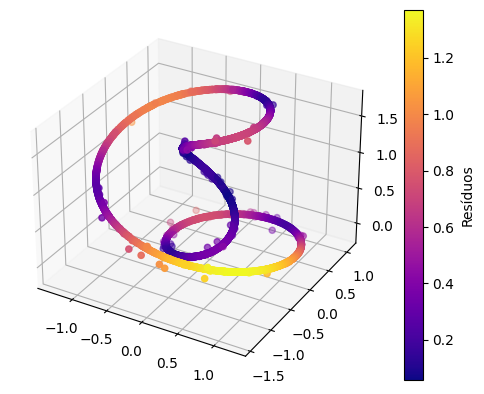

In [ ]:
Q_mlp.evaluate(X_teste, y_teste)
y_pred = Q_mlp.predict(X_teste)

residuos = []
for i in range(len(y_teste)):
  residuos.append(np.linalg.norm(y_teste[i]-y_pred[i]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(y_teste[:, 0], y_teste[:, 1], y_teste[:, 2], c=residuos, cmap='plasma')
cbar = plt.colorbar(scatter)
cbar.set_label('Resíduos')
plt.show()

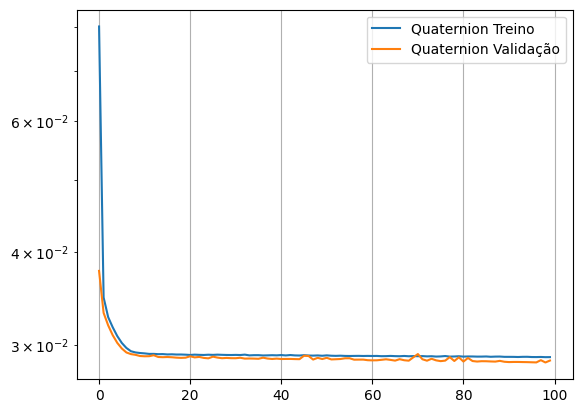

In [ ]:
plt.semilogy(q_hist.history['loss'],label='Quaternion Treino')
plt.semilogy(q_hist.history['val_loss'],label='Quaternion Validação')

plt.legend()
plt.grid()

## Outra codificação dos pontos reais para quaterniônicos

In [ ]:
sample_space , target, dados_gerais = prep_data(aizawa, n_points, 4)
X_treino, X_teste, y_treino, y_teste = train_test_split(sample_space, target, test_size= 0.2, random_state= 42)
X_val, X_teste, y_val, y_teste = train_test_split(X_teste, y_teste, test_size=0.6, random_state= 123)

In [ ]:
#Adicionando uma componente escalar aos vetores - considerando que as entradas x, y, z correspondem
#às componentes î, ĵ e k^ respectivamente.

t = np.zeros((X_treino.shape[0], X_treino.shape[1], 1))
X_treino = np.c_[t, X_treino]

t = np.zeros((X_teste.shape[0], X_teste.shape[1], 1))
X_teste = np.c_[t, X_teste]

t = np.zeros((X_val.shape[0], X_val.shape[1], 1))
X_val = np.c_[t, X_val]

t = np.zeros(y_treino.shape[0])
y_treino = np.c_[t, y_treino]

t = np.zeros(y_teste.shape[0])

y_teste = np.c_[t, y_teste]

t = np.zeros(y_val.shape[0])
y_val = np.c_[t, y_val]

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [ ]:
X_treino = X_treino.reshape(X_treino.shape[0], X_treino.shape[1]*X_treino.shape[2])
X_teste = X_teste.reshape(X_teste.shape[0], X_teste.shape[1]*X_teste.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2])

X_treino.shape, y_treino.shape

((32000, 12), (32000, 3))

In [ ]:
input = keras.Input(shape=(X_treino.shape[1],))
output_quart = V_Dense(algebra=quaternion_numbers,units=7,activation='relu')(input)
output_final = V_Dense(algebra=quaternion_numbers, units=1, activation=None, use_bias=None)(output_quart)
Q_mlp = Model(inputs=input, outputs=output_final, name="quatenionic_neuron")

In [ ]:
Q_mlp.summary()

Model: "quatenionic_neuron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16)]              0         
                                                                 
 v__dense_2 (V_Dense)        (None, 28)                140       
                                                                 
 v__dense_3 (V_Dense)        (None, 4)                 28        
                                                                 
Total params: 168 (672.00 Byte)
Trainable params: 168 (672.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
Q_mlp.compile(loss='mse',optimizer='adam', metrics=['mae'])

In [ ]:
q_hist = Q_mlp.fit(X_treino, y_treino,
epochs=100,
validation_data=(X_val,y_val), verbose=True)

Epoch 1/100
1000/1000 [==============================] - 3s 2ms/step - loss: 0.0529 - mae: 0.1076 - val_loss: 9.5436e-04 - val_mae: 0.0245
Epoch 2/100
1000/1000 [==============================] - 2s 2ms/step - loss: 5.5172e-04 - mae: 0.0182 - val_loss: 3.0357e-04 - val_mae: 0.0134
Epoch 3/100
1000/1000 [==============================] - 2s 2ms/step - loss: 2.4127e-04 - mae: 0.0116 - val_loss: 1.7072e-04 - val_mae: 0.0097
Epoch 4/100
1000/1000 [==============================] - 2s 2ms/step - loss: 1.3643e-04 - mae: 0.0085 - val_loss: 9.6323e-05 - val_mae: 0.0073
Epoch 5/100
1000/1000 [==============================] - 2s 2ms/step - loss: 8.0251e-05 - mae: 0.0067 - val_loss: 6.0747e-05 - val_mae: 0.0059
Epoch 6/100
1000/1000 [==============================] - 5s 5ms/step - loss: 5.3540e-05 - mae: 0.0055 - val_loss: 4.6335e-05 - val_mae: 0.0053
Epoch 7/100
1000/1000 [==============================] - 3s 3ms/step - loss: 3.9710e-05 - mae: 0.0048 - val_loss: 3.3877e-05 - val_mae: 0.0043
Epo

150/150 [==============================] - 0s 1ms/step


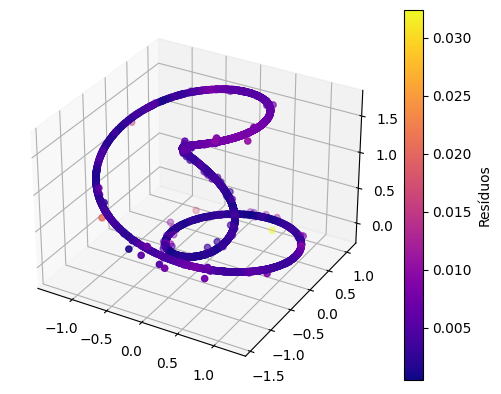

In [ ]:
Q_mlp.evaluate(X_teste, y_teste)
y_pred = Q_mlp.predict(X_teste)

residuos = []
for i in range(len(y_teste)):
  residuos.append(np.linalg.norm(y_teste[i]-y_pred[i]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(y_teste[:, 1], y_teste[:, 2], y_teste[:, 3], c=residuos, cmap='plasma')
cbar = plt.colorbar(scatter)
cbar.set_label('Resíduos')
plt.show()

In [ ]:
#MAE fidedigno
np.mean(np.mean(np.abs(y_pred[:, 1:]-y_teste[:, 1:]), axis=0))

0.0018950158064984443

# Teste Exaustivo

In [ ]:
def teste_modelo(modelo, X_treino, y_treino, X_val, y_val, X_teste, y_teste):
    modelo.fit(
    X_treino, y_treino,
    verbose=0,epochs=100,
    validation_data=(X_val, y_val))

    return list(modelo.evaluate(X_teste,y_teste))

def analise_exaustiva(model_type, data_base , n_info, n_points, num_iter, algebra_matrix=None):
  #Preparando os dados
  sample_space , target, dados_gerais = prep_data(data_base, n_points, n_info)
  X_treino, X_teste, y_treino, y_teste = train_test_split(sample_space, target, test_size= 0.2)
  X_val, X_teste, y_val, y_teste = train_test_split(X_teste, y_teste, test_size=0.6)
  X_treino = X_treino.reshape(X_treino.shape[0], X_treino.shape[1] * X_treino.shape[2])
  X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])
  X_teste = X_teste.reshape(X_teste.shape[0], X_teste.shape[1] * X_teste.shape[2])

  #Teste do Modelo requerido
  if model_type == 'Complex':
    y_treino, y_teste, y_val = Real2Complex(y_treino), Real2Complex(y_teste), Real2Complex(y_val)
    resultados = []
    for _ in range(num_iter):
      input = keras.Input(shape=(X_treino.shape[1],))
      input_complex = Real2Complex(input)
      output_complex = ComplexDense(5, activation='relu')(input_complex)
      output_final = ComplexDense(3, activation=None, use_bias=None)(output_complex)
      single_complex = Model(inputs=input, outputs=output_final, name="complex_neuron")
      single_complex.compile(loss='mse',optimizer='adam', metrics=['mae'])
      resultados.append(teste_modelo(single_complex, X_treino, y_treino, X_val, y_val, X_teste, y_teste))

  elif model_type == 'Real':
    sample_space , target, dados_gerais = prep_data(data_base, n_points, n_info)
    sample_space = sample_space.reshape((sample_space.shape[0], 1, n_info*3))
    X_treino, X_teste, y_treino, y_teste = train_test_split(sample_space, target, test_size= 0.2)
    X_val, X_teste, y_val, y_teste = train_test_split(X_teste, y_teste, test_size=0.6)
    resultados = []

    for _ in range(num_iter):
      print(f'{_} iteração')
      model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(1, n_info*3)),
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.Dense(3)
      ])
      model.compile(loss='mse',optimizer='adam', metrics=['mae'])
      resultados.append(teste_modelo(model, X_treino, y_treino, X_val, y_val, X_teste, y_teste))

  elif model_type == 'Quartenionic_Cod01':
    y_treino, y_teste, y_val = Real2Quart(y_treino), Real2Quart(y_teste), Real2Quart(y_val)
    resultados = []
    for _ in range(num_iter):
      print(f'{_} iteração')
      input = keras.Input(shape=(X_treino.shape[1],))
      input_quart = Real2Quart(input)
      output_quart = V_Dense(algebra=algebra_matrix,units=2,activation='relu')(input_quart)
      output_final = V_Dense(algebra=algebra_matrix, units=3, activation=None, use_bias=None)(output_quart)
      Q_mlp = Model(inputs=input, outputs=output_final, name="quatenionic_neuron")
      Q_mlp.compile(loss='mse',optimizer='adam', metrics=['mae'])
      resultados.append(teste_modelo(Q_mlp, X_treino, y_treino, X_val, y_val, X_teste, y_teste))

  elif model_type == 'Quartenionic_Cod02':
      resultados = []
      sample_space , target, dados_gerais = prep_data(data_base, n_points, n_info)
      X_treino, X_teste, y_treino, y_teste = train_test_split(sample_space, target, test_size= 0.2)
      X_val, X_teste, y_val, y_teste = train_test_split(X_teste, y_teste, test_size=0.6)
      #Nova Codificação dos pontos reais
      t = np.zeros((X_treino.shape[0], X_treino.shape[1], 1))
      X_treino = np.c_[t, X_treino]
      t = np.zeros((X_teste.shape[0], X_teste.shape[1], 1))
      X_teste = np.c_[t, X_teste]
      t = np.zeros((X_val.shape[0], X_val.shape[1], 1))
      X_val = np.c_[t, X_val]
      t = np.zeros(y_treino.shape[0])
      y_treino = np.c_[t, y_treino]
      t = np.zeros(y_teste.shape[0])
      y_teste = np.c_[t, y_teste]
      t = np.zeros(y_val.shape[0])
      y_val = np.c_[t, y_val]
      X_treino = X_treino.reshape(X_treino.shape[0], X_treino.shape[1] * X_treino.shape[2])
      X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])
      X_teste = X_teste.reshape(X_teste.shape[0], X_teste.shape[1] * X_teste.shape[2])


      for _ in range(num_iter):
        print(f'{_ + 1}a iteração')
        input = keras.Input(shape=(X_treino.shape[1],))
        output_quart = V_Dense(algebra=algebra_matrix,units=2,activation='relu')(input_quart)
        output_final = V_Dense(algebra=algebra_matrix, units=3, activation=None, use_bias=None)(output_quart)
        Q_mlp = Model(inputs=input, outputs=output_final, name="quatenionic_neuron")
        Q_mlp.compile(loss='mse',optimizer='adam', metrics=['mae'])
        resultados.append(teste_modelo(Q_mlp, X_treino, y_treino, X_val, y_val, X_teste, y_teste))

In [ ]:
resultados_real = analise_exaustiva(model_type='Real',data_base=aizawa, n_info=4 , n_points=n_points,num_iter= 3)

0 iteração
[]
150/150 [==============================] - 0s 1ms/step - loss: 1.1707e-06 - mae: 8.6037e-04
1 iteração
[[1.1707400062732631e-06, 0.0008603677270002663]]
150/150 [==============================] - 0s 1ms/step - loss: 3.9869e-06 - mae: 0.0015
2 iteração
[[1.1707400062732631e-06, 0.0008603677270002663], [3.98687734559644e-06, 0.0015433916123583913]]
150/150 [==============================] - 0s 1ms/step - loss: 3.8591e-06 - mae: 0.0014


In [ ]:
print(resultados_real)

TypeError: 'NoneType' object is not subscriptable

# Visualizações

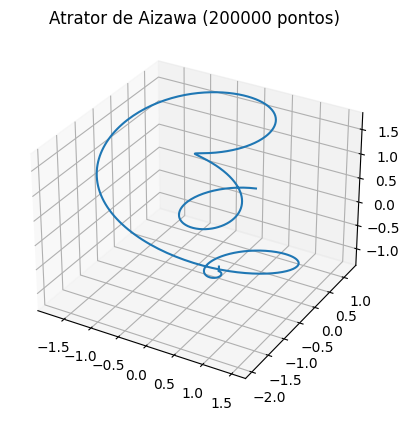

In [ ]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(aizawa[:, 0], aizawa[:, 1], aizawa[:, 2])
plt.title(f'Atrator de Aizawa ({n_points} pontos)')
plt.show()


- O código demora muito pra rodar, pq gera um gif, mas se quiser ver, só descomentar a última linha



-   Teste de animação




In [ ]:


import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook
a = lorentz
t = np.array([np.ones(100) * i for i in range(int(n_points/100))]).flatten()
df = pd.DataFrame({"time": t, "x": a[:, 0], "y": a[:, 1], "z": a[:, 2]})

# Função de atualização para a animação
def update_graph(num):
    ax.clear()  # Limpa o eixo para evitar sobreposição de gráficos
    data = df[df['time'] == num]
    graph = ax.scatter(data['x'], data['y'], data['z'])
    title.set_text('3D Test, time={}'.format(num))
    return graph, title

# Configuração da figura e do eixo 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('3D Test')

# Criação da animação
anim = FuncAnimation(fig, update_graph, frames=range(20), interval=40, blit=True)

#anim.save('animation.mp4')

plt.show()

<IPython.core.display.Javascript object>